## Testing Aral Sea Volume stuff

In [161]:
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

import fiona
import shapely.geometry
from pyproj import Geod



In [162]:
results = pd.read_csv(
    "HBV_AralBasin_5000.csv",
    index_col=0,          # use first column as index
    parse_dates=True      # automatically parse as datetime if possible
)

observations = pd.read_csv("BathyData.txt", sep="\t", header=None, names=["year", "value"])

# Convert the first column to datetime and set as index
observations.index = pd.to_datetime(observations["year"], format="%Y")

# Optionally drop the original year column
observations = observations.drop(columns="year")


aral_meteo = xr.open_dataset('/home/avandervee3/MSc_AralSea/book/thesis_projects/MSc/2025_Q1_AndreVanDerVeen_CEG/work_in_progress/Test_Aral/forcing_Sea_HBV_5000/AralSea/ERA5/own_shapefile/work/diagnostic/script/Derived_Makkink_evspsblpot.nc')

In [163]:
observations

,value
year,
1950-01-01,1058.0
1951-01-01,1049.0
1952-01-01,1050.0
1953-01-01,1059.0
1954-01-01,1076.0
1955-01-01,1079.0
1956-01-01,1082.0
1957-01-01,1080.0
1958-01-01,1078.0


In [164]:
conversion_mmday2m3s = 1 / (1000 * 86400)
shape = fiona.open('/home/avandervee3/MSc_AralSea/book/thesis_projects/MSc/2025_Q1_AndreVanDerVeen_CEG/work_in_progress/Test_Aral/AralSea_Basin/AralSeaBasin.shp')
poly = [shapely.geometry.shape(p["geometry"]) for p in shape][0]
geod = Geod(ellps="WGS84")
poly_area, poly_perimeter = geod.geometry_area_perimeter(poly)
catchment_area_m2 = abs(poly_area)
print(f"{catchment_area_m2 = }")

results['Modelled_discharge'] = results['Modelled_discharge']* conversion_mmday2m3s * catchment_area_m2

catchment_area_m2 = 1845542301721.4697


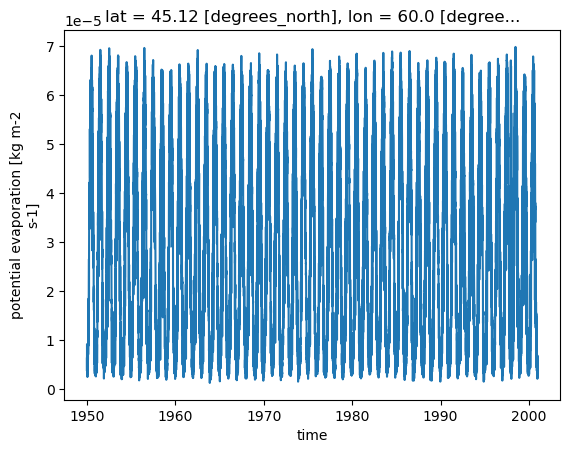

In [165]:
aral_meteo['evspsblpot'].plot()

In [166]:
Aral_Table = pd.read_csv('Aral_Tabel.csv', sep=';',skipfooter=1,engine = 'python')
Aral_Table['Year'] = pd.to_datetime(Aral_Table['Year'], format='%Y')

# Set as index
Aral_Table.set_index('Year', inplace=True)

# Optional: sort by index if needed
Aral_Table.sort_index(inplace=True)



In [167]:
# Your data
volumes_inter = Aral_Table['Volume']
areas_inter = Aral_Table['Area']  # in km²

# Interpolation functions
V_of_A = interp1d(areas_inter, volumes_inter, kind='linear', fill_value="extrapolate")
A_of_V = interp1d(volumes_inter, areas_inter, kind='linear', fill_value="extrapolate")

# Fine grids for plotting
area_grid = np.linspace(min(areas_inter), max(areas_inter), 200)
vol_grid = np.linspace(min(volumes_inter), max(volumes_inter), 200)

# Interpolated values
vol_interp = V_of_A(area_grid)
area_interp = A_of_V(vol_grid)

# Extend grids down to 0
area_grid_ext = np.linspace(0, max(areas_inter), 300)
vol_grid_ext = np.linspace(0, max(volumes_inter), 300)

# Interpolated with extrapolation
vol_interp_ext = V_of_A(area_grid_ext)
area_interp_ext = A_of_V(vol_grid_ext)



## test ongeveer begin

- v0 = 1100 km3
- volledig debiet - overschatting

In [168]:

Initial_volume_AralSea_km3 = 1100 

experiment_start_date = results.index.min().strftime("%Y-%m-%d")  
experiment_end_date = results.index.max().strftime("%Y-%m-%d")
n = len(results.index)



Volume_Aral_Sea_km3 = pd.Series(0.0, index=results.index, name='Volume_Aral_Sea_km3')
Area_Aral_Sea_km2 = pd.Series(0.0, index=results.index, name='Area_Aral_Sea_km2')
Volume_Aral_Sea_km3.iloc[0] = Initial_volume_AralSea_km3
Area_Aral_Sea_km2.iloc[0] = A_of_V(Volume_Aral_Sea_km3.iloc[0])






In [169]:
observations['area']=A_of_V(observations['value'])
observations.head()

,value,area
year,,
1950-01-01,1058.0,65137.330017
1951-01-01,1049.0,64577.755372
1952-01-01,1050.0,64639.904132
1953-01-01,1059.0,65199.850746
1954-01-01,1076.0,66240.067055


In [170]:
for i in range(1, n):
    # Inflow from rivers (km3/day)
    Q_day_m3day_Chatly = results.iloc[i, results.columns.get_loc('Modelled_discharge')] * 86400 / 1e9 
    #Q_day_m3day_Kazalinsk = results.iloc[i, results.columns.get_loc('Kazalinsk')] * 86400 / 1e9
    Q_day_m3day_Kazalinsk = 0

    # Test factor to adjust inflow (calibration)
    testfactor = 1
    #testfactor =0.25
    # Groundwater inflow
    Q_day_m3day_GW_in = 0 #0.5/365

    #local precipitation
    #TODO



    # Evaporation
    Potential_evap = aral_meteo['evspsblpot'].isel(time=i).values
    Area_Aral_Sea_km2.iloc[i] = A_of_V(Volume_Aral_Sea_km3.iloc[i-1])
    Evaporation_Aral_Sea_km3day = Potential_evap * Area_Aral_Sea_km2.iloc[i] * 60 * 60 * 24 * 1e-12 * 1e6

    # Update volume
    Volume_Aral_Sea_km3.iloc[i] = (
        Volume_Aral_Sea_km3.iloc[i-1] 
        + testfactor * (Q_day_m3day_Chatly + Q_day_m3day_Kazalinsk) 
        - Q_day_m3day_GW_in 
        - Evaporation_Aral_Sea_km3day
    )

    # Prevent negative volume
    if Volume_Aral_Sea_km3.iloc[i] < 0:
        Volume_Aral_Sea_km3.iloc[i] = 0






df = pd.DataFrame({
    'Volume': Volume_Aral_Sea_km3,
    'Area': Area_Aral_Sea_km2
})


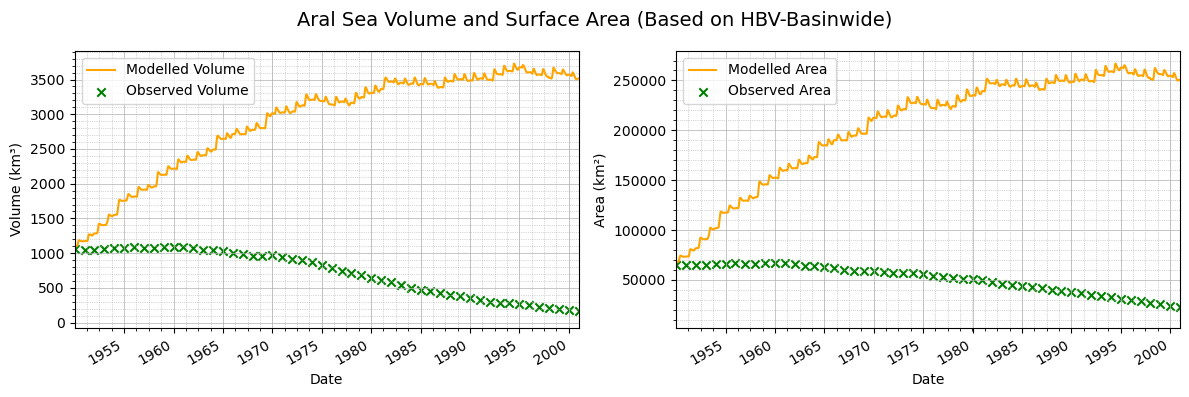

In [178]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# Plot modelled volume
df['Volume'].plot(ax=ax[0], label='Modelled Volume', color='orange')

# Plot observed volume as scatter
ax[0].scatter(observations.index, observations['value'],
              color='green', marker='x', label='Observed Volume')

#ax[0].set_title('Volume of the Aral Sea over time')
ax[0].set_ylabel('Volume (km³)')
ax[0].set_xlabel('Date')
ax[0].set_xlim(experiment_start_date, experiment_end_date)
ax[0].legend()
ax[0].grid(True, which='major', linestyle='-', linewidth=0.5)
ax[0].grid(True, which='minor', linestyle=':', linewidth=0.5)
ax[0].minorticks_on()

# Plot modelled area
df['Area'].plot(ax=ax[1], label='Modelled Area', color='orange')

# Plot observed area as scatter
ax[1].scatter(observations.index, observations['area'],
              color='green', marker='x', label='Observed Area')

#ax[1].set_title('Surface Area of the Aral Sea over time')
ax[1].set_ylabel('Area (km²)')
ax[1].set_xlabel('Date')
ax[1].set_xlim(experiment_start_date, experiment_end_date)
ax[1].legend()
ax[1].grid(True, which='major', linestyle='-', linewidth=0.5)
ax[1].grid(True, which='minor', linestyle=':', linewidth=0.5)
ax[1].minorticks_on()

plt.suptitle('Aral Sea Volume and Surface Area (Based on HBV-Basinwide)', fontsize=14)
plt.tight_layout()
plt.savefig('Aral_Sea_Volume_Area_5000.png', bbox_inches='tight', pad_inches=0.05, dpi=200)
plt.show()


In [172]:
from ewatercycle.observation.grdc import get_grdc_data

ds = get_grdc_data(2617110,
                   '1900-01-01T00:00Z',
                   '2001-01-01T00:00Z',
                   data_home='/home/avandervee3/MSc_AralSea/book/thesis_projects/MSc/2025_Q1_AndreVanDerVeen_CEG/work_in_progress/Test_Aral/')
ds

<xarray.Dataset> Size: 316kB
Dimensions:              (time: 19724)
Coordinates:
  * time                 (time) datetime64[ns] 158kB 1936-01-01 ... 1989-12-31
    id                   int64 8B 2617110
Data variables:
    streamflow           (time) float64 158kB 914.0 938.0 926.0 ... 604.0 583.0
    area                 float64 8B 3.09e+05
    country              <U2 8B 'TM'
    geo_x                float64 8B 65.25
    geo_y                float64 8B 37.83
    geo_z                float64 8B 241.0
    owneroforiginaldata  <U85 340B 'Initial dataset collected in the framewor...
    river_name           <U9 36B 'AMU DARYA'
    station_name         <U5 20B 'KERKI'
    timezone             float64 8B nan
Attributes:
    title:          NA
    Conventions:    CF-1.7
    references:     grdc.bafg.de
    institution:    GRDC
    history:        Converted from 2617110_Q_Day.Cmd.txt of 2025-09-02 to net...
    missing_value:  -999.000

## test ongeveer nu
- debiet 10-15% van pcrglob
- v0 = 150 



In [173]:
Initial_volume_AralSea_km3 = 100 

experiment_start_date = results.index.min().strftime("%Y-%m-%d")  
experiment_end_date = results.index.max().strftime("%Y-%m-%d")
n = len(results.index)



Volume_Aral_Sea_km3 = pd.Series(0.0, index=results.index, name='Volume_Aral_Sea_km3')
Area_Aral_Sea_km2 = pd.Series(0.0, index=results.index, name='Area_Aral_Sea_km2')
Volume_Aral_Sea_km3.iloc[0] = Initial_volume_AralSea_km3
Area_Aral_Sea_km2.iloc[0] = A_of_V(Volume_Aral_Sea_km3.iloc[0])


In [174]:



for i in range(1, n):
    # Inflow from rivers (km3/day)
    Q_day_m3day_Chatly = results.iloc[i, results.columns.get_loc('Chatly')] * 86400 / 1e9 
    Q_day_m3day_Kazalinsk = results.iloc[i, results.columns.get_loc('Kazalinsk')] * 86400 / 1e9
    testfactor = 1
    
    
        # Groundwater inflow
    Q_day_m3day_GW_in = 0 #0.5/365

    #local precipitation
    #TODO



    # Evaporation
    Potential_evap = aral_meteo['evspsblpot'].isel(time=i).values
    Area_Aral_Sea_km2.iloc[i] = A_of_V(Volume_Aral_Sea_km3.iloc[i-1])
    Evaporation_Aral_Sea_km3day = Potential_evap * Area_Aral_Sea_km2.iloc[i] * 60 * 60 * 24 * 1e-12 * 1e6

    # Update volume
    Volume_Aral_Sea_km3.iloc[i] = (
        Volume_Aral_Sea_km3.iloc[i-1] 
        + testfactor * (Q_day_m3day_Chatly + Q_day_m3day_Kazalinsk) 
        - Q_day_m3day_GW_in 
        - Evaporation_Aral_Sea_km3day
    )

    # Prevent negative volume
    if Volume_Aral_Sea_km3.iloc[i] < 0:
        Volume_Aral_Sea_km3.iloc[i] = 0



fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Plot Volume
Volume_Aral_Sea_km3.plot(ax=ax[0])
#Aral_Table['Volume'].plot(ax=ax[0])  # TODO: add observed volume data if available
ax[0].set_title('Volume of the Aral Sea')
ax[0].set_ylabel('Volume (km³)')
ax[0].set_xlabel('Date')
ax[0].grid(True)  # Add grid
#ax[0].legend(['Simulated Volume', 'Observed Volume'])

# Plot Area
Area_Aral_Sea_km2.plot(ax=ax[1], color='orange')
ax[1].set_title('Surface Area of the Aral Sea')
ax[1].set_ylabel('Area (km²)')
ax[1].set_xlabel('Date')
ax[1].grid(True)  # Add grid

# Figure-level title
fig.suptitle('Aral Sea – Modelled Volume and Surface Area', fontsize=14)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make room for suptitle
plt.savefig('modelled_aralsea_pp.png')
plt.show()

KeyError: 'Chatly'

In [ ]:
df = ds.to_dataframe().reset_index()
df = df.reset_index().set_index('time')  # set 'time' as index

In [ ]:
df